# Agenda
Classification of GPs' bitmaps.



In [1]:
# Installing Libraries (if not installed)
#!pip3 install jupyterlab-git
#!pip3 install voila
#!pip3 install matplotlib
#!pip3 install scikit-learn
#!pip3 install seaborn
#!pip3 install numpy
#!pip3 install pandas
#!pip3 install so4gp
#!pip3 install scipy
#!pip3 install sympy
#!pip3 install networkx

# Import libraries <a name="lib-import"></a>

In [2]:
# Importing Libraries
import pandas as pd
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
#import seaborn as sns
#import sympy
import scipy
import math


from scipy.sparse import csgraph, csr_matrix
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import kneighbors_graph
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import homogeneity_score, completeness_score,v_measure_score, confusion_matrix, accuracy_score
from numpy import linalg as la

In [3]:
import so4gp as sgp

# Data set
Retrieving data set and the features

In [4]:
ds = sgp.DataGP('../data/DATASET.csv')
#ds = sgp.DataGP('../data/c2k_02k.csv')
#ds = sgp.DataGP('../data/breast_cancer.csv')


data_size = ds.row_count
feature_size = ds.col_count
features = np.array(ds.data, dtype=np.float64)
features

array([[30.,  3.,  1., 10.,  2.,  4.],
       [35.,  2.,  2.,  8.,  2.,  4.],
       [40.,  4.,  2.,  7.,  2.,  4.],
       [50.,  1.,  1.,  6.,  2.,  4.],
       [52.,  7.,  1.,  2.,  2.,  4.]])

In [5]:
sgp.graank('../data/breast_cancer.csv', min_sup=0.6)

'{"Algorithm": "GRAANK", "Patterns": [[["Insulin+", "BMI+"], 0.612], [["BMI+", "HOMA+"], 0.614], [["BMI+", "Leptin+"], 0.732], [["Insulin-", "BMI-"], 0.612], [["HOMA-", "BMI-"], 0.614], [["Leptin-", "BMI-"], 0.732], [["Insulin+", "Glucose+"], 0.637], [["HOMA+", "Glucose+"], 0.697], [["Glucose-", "Insulin-"], 0.637], [["HOMA-", "Glucose-"], 0.697], [["Insulin+", "HOMA+"], 0.94], [["Insulin+", "Leptin+"], 0.659], [["HOMA-", "Insulin-"], 0.94], [["Leptin-", "Insulin-"], 0.659], [["HOMA+", "Leptin+"], 0.659], [["HOMA-", "Leptin-"], 0.659], [["MCP.1+", "Resistin+"], 0.672], [["Resistin-", "MCP.1-"], 0.672], [["Insulin+", "HOMA+", "Glucose+"], 0.637], [["HOMA-", "Glucose-", "Insulin-"], 0.637], [["Insulin+", "HOMA+", "Leptin+"], 0.629], [["HOMA-", "Leptin-", "Insulin-"], 0.629]]}'

In [6]:
feature_X = features[:, [1,3]]
feature_X

array([[ 3., 10.],
       [ 2.,  8.],
       [ 4.,  7.],
       [ 1.,  6.],
       [ 7.,  2.]])

# Semi-Supervised Learning

Train similirity labels

## a. Retrieving training data set (X, y)

In [7]:
def compute_nz(row, i, val=0):
    #print(row[i:])
    nz = np.nonzero(row)
    for k in range(nz[0].size):
        if nz[0].size > 0:
            j = nz[0][k]
            if (j > i) and (val == 0):
                return j
            elif (j > i) and (row[j] == val):
                return j
    return 0

In [8]:
def compute_path(j, X, path, path_val):
    if type(path) != list:
        # 1st iteration
        # print("Print Once: " + str(j))
        return compute_path(j, X, [path, j], path_val)
    
    k = compute_nz(X[j],j,val=path_val)
    j += 1
    if k > 0:
        path.append(k)
        if k < data_size:
            return compute_path(k, X, path, path_val)
    elif j < data_size:
        return compute_path(j, X, path, path_val)
    else:
        return path
    

In [9]:
def construct_pairs():
    X = []
    for i in range(data_size):
        for j in range(i+1, data_size):
            x = []
            for k in range(feature_size):
                #temp = [features[i][k], features[j][k]]
                #x.append(temp)
                x.append(features[j][k] - features[i][k])
            X.append(x)
    return np.array(X, dtype=float)

In [10]:
# X (2 features at a time)
X = np.zeros((data_size, data_size))
y  = np.zeros((data_size,))
enc = {"upup": 1, "updown": 2}

for i in range(data_size):
    for j in range(data_size):
        x_i = feature_X[i]
        x_j = feature_X[j]
        if i == j:
            pass
        elif (x_i[0] > x_j[0]) and (x_i[1] > x_j[1]):
            X[i][j] = enc["upup"]
            X[j][i] = enc["upup"]
        elif (x_i[0] > x_j[0]) and (x_i[1] < x_j[1]):
            X[i][j] = enc["updown"]
            X[j][i] = enc["updown"]

longest_path = []
longest_path_val = 0

for i in range(data_size):
    # Column i, Row j
    path_val = enc["upup"]
    #path_val = enc["updown"]
    j = compute_nz(X[i],i, val=path_val)
    if j > 0:
        # path_val = X[i][j]
        # print(str(i) + ' ' + str(j))
        path = compute_path(j, X, i, path_val)
        if len(path) > len(longest_path):
            longest_path = path
            longest_path_val = path_val
y[longest_path] = longest_path_val

print(longest_path)
print("\n")
X

[0, 1, 3]




array([[0., 1., 2., 1., 2.],
       [1., 0., 2., 1., 2.],
       [2., 2., 0., 1., 2.],
       [1., 1., 1., 0., 2.],
       [2., 2., 2., 2., 0.]])

In [11]:
# Using a modified data set

Xp = construct_pairs()
print(Xp)
#Xp[:, 0:2]

[[ 5. -1.  1. -2.  0.  0.]
 [10.  1.  1. -3.  0.  0.]
 [20. -2.  0. -4.  0.  0.]
 [22.  4.  0. -8.  0.  0.]
 [ 5.  2.  0. -1.  0.  0.]
 [15. -1. -1. -2.  0.  0.]
 [17.  5. -1. -6.  0.  0.]
 [10. -3. -1. -1.  0.  0.]
 [12.  3. -1. -5.  0.  0.]
 [ 2.  6.  0. -4.  0.  0.]]


In [12]:
yp = [2, 1, 2, 1, 1, 2, 1, 2, 1, 1]
print(yp)

[2, 1, 2, 1, 1, 2, 1, 2, 1, 1]


## b. Splitting Samples

Splitting test (20%) and train samples (80%) 

In [13]:
# Splitting the dataset into the Training set (0.5 of data set sample) and Test set (0.5 of sample size)
#X_train, X_test, y_train, y_test = train_test_split(Xp[:, 0:4], yp, test_size = 0.2, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [14]:
# Feature Scaling (if you have large values otherwise skip)

#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

## c. Training Classifiers

### 1. KNN Classifier

Using supervised learning

Adopted from [Analyticsvidhya](https://www.analyticsvidhya.com/blog/2021/01/a-quick-introduction-to-k-nearest-neighbor-knn-classification-using-python/)

In [15]:
# Training the K-NN model on the Training set
n = int(math.sqrt(data_size))
knn_classifier = KNeighborsClassifier(n_neighbors = n, metric = 'minkowski', p = 2)  # default parameters
knn_classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = knn_classifier.predict(X_test)
y_pred

array([1.])

In [16]:
# Making the Confusion Matrix
confusion_matrix(y_test, y_pred), accuracy_score(y_test, y_pred)

(array([[0, 1],
        [0, 0]]),
 0.0)

### 2. Naive Bayes Classifier

In [17]:
# Training the NB model on the Training set
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = nb_classifier.predict(X_test)
y_pred

array([1.])

In [18]:
# Making the Confusion Matrix
confusion_matrix(y_test, y_pred), accuracy_score(y_test, y_pred)

(array([[0, 1],
        [0, 0]]),
 0.0)

### 3. SVM Classifier

In [19]:
# Training the SVC model on the Training set
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = svm_classifier.predict(X_test)
y_pred

array([1.])

In [20]:
# Making the Confusion Matrix
confusion_matrix(y_test, y_pred), accuracy_score(y_test, y_pred)

(array([[0, 1],
        [0, 0]]),
 0.0)

## d. Testing Classifiers of Real Data


In [21]:
# True labels (y)
np.unique(y, return_counts=True)

(array([0., 1.]), array([2, 3]))

### 1. KMeans Classification
Produces labels that are not very accurate in partitioning data points.

(array([0., 1.]), array([1, 4]))
[1. 1. 1. 1. 0.]


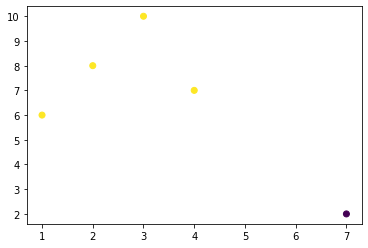

In [22]:
# Validation
# Using KMeans classification (NOT VERY  ACCURATE)

kmean_labels = knn_classifier.predict(X)
#kmean_labels = knn_classifier.predict(Xp[:, 0:4])
print(np.unique(kmean_labels, return_counts=True))
print(kmean_labels)

plt.scatter(feature_X[:,0], feature_X[:,1], c=kmean_labels)
#plt.scatter(feature_X[:,0], feature_X[:,1], c=y )

plt.show()

In [23]:
# Evaluation of clustering result of KMeans (true_labels, predicted_labels)
homogeneity_score(y, kmean_labels), completeness_score(y, kmean_labels), v_measure_score(y, kmean_labels), accuracy_score(y, kmean_labels)#, confusion_matrix(y, kmean_labels)
#accuracy_score(yp, kmean_labels)

(0.3315597072868288, 0.44592819862148547, 0.38033214891787165, 0.8)

### 2. Naive Bayes Classification

Produces labels

(array([0., 1.]), array([1, 4]))
[1. 1. 1. 1. 0.]


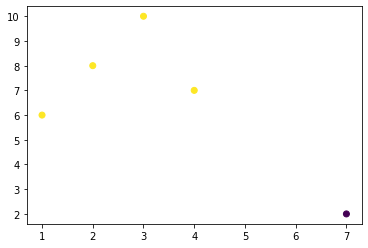

In [24]:
# Validation
# Using Naive Bayes classification

nb_labels = nb_classifier.predict(X)
print(np.unique(nb_labels, return_counts=True))
print(nb_labels)

plt.scatter(feature_X[:,0], feature_X[:,1], c=nb_labels)
#plt.scatter(feature_X[:,0], feature_X[:,1], c=y )

plt.show()

In [25]:
# Evaluation of clustering result of KMeans (true_labels, predicted_labels)
homogeneity_score(y, nb_labels), completeness_score(y, nb_labels), v_measure_score(y, nb_labels), accuracy_score(y, nb_labels)#, confusion_matrix(y, kmean_labels)

(0.3315597072868288, 0.44592819862148547, 0.38033214891787165, 0.8)

### 3. SVM Classification

Produces labels

(array([0., 1.]), array([1, 4]))
[1. 1. 1. 1. 0.]


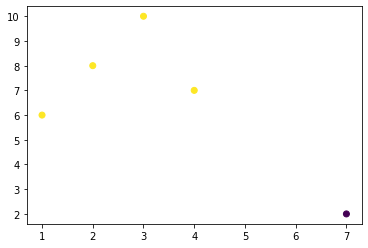

In [26]:
# Validation
# Using Naive Bayes classification

svm_labels = svm_classifier.predict(X)
print(np.unique(svm_labels, return_counts=True))
print(svm_labels)

plt.scatter(feature_X[:,0], feature_X[:,1], c=svm_labels)
#plt.scatter(feature_X[:,0], feature_X[:,1], c=y )

plt.show()

In [27]:
# Evaluation of clustering result of KMeans (true_labels, predicted_labels)
homogeneity_score(y, svm_labels), completeness_score(y, svm_labels), v_measure_score(y, svm_labels), accuracy_score(y, svm_labels)#, confusion_matrix(y, kmean_labels)

(0.3315597072868288, 0.44592819862148547, 0.38033214891787165, 0.8)